# PySpark Movie Recommendation System

## Step 1: Setup

We start by importing the necessary libraries and setting up our Spark session.

In [21]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, col, lit

In [22]:
# Create SparkSession
spark = SparkSession.builder.appName("recommender_system").getOrCreate()

## Step 2: Load Data

We load the dataset into a Spark DataFrame and inspect the first few rows.

In [23]:
# load the dataset and create sprk dataframe
df = spark.read.csv("./data/movie_ratings.csv", inferSchema=True, header=True)

# Using toPandas() method to return Pyspark DataFrame as Pandas table
df.limit(3).toPandas()

,userId,title,rating
0,196,Kolya (1996),3
1,63,Kolya (1996),3
2,226,Kolya (1996),5


In [24]:
df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- rating: integer (nullable = true)



## Step 3: Indexing Movie Titles

We use StringIndexer to convert movie titles into numerical indices for the ALS algorithm.

In [25]:
from pyspark.ml.feature import StringIndexer, IndexToString

# IMPORT STRINGINDEXER AND INDEXTOSTRING FROM THE Pyspark.ml.feature MODULE

stringIndexer = StringIndexer(inputCol="title", outputCol="title_new")
# CREATE STRINGINDEXER OBJECT TO TRANSFORM 'title' COLUMN TO 'title_new' WITH NUMERICAL INDICES

# APPLY STRINGINDEXER OBJECT ON DATAFRAME MOVIE TITLE COLUMN
model = stringIndexer.fit(df)
# FIT THE STRINGINDEXER MODEL TO THE DATAFRAME 'df' TO DETERMINE STRING TO INDEX MAPPING

# CREATE NEW DATAFRAME WITH TRANSFORMED VALUES
indexed = model.transform(df)
# APPLY THE FITTED STRINGINDEXER MODEL TO 'df' TO TRANSFORM 'title' COLUMN INTO 'title_new' WITH NUMERICAL INDICES

# VALIDATE THE NUMERICAL TITLE VALUES
indexed.limit(5).toPandas()
# LIMIT THE NEW DATAFRAME TO THE FIRST 5 ROWS AND CONVERT TO A PANDAS DATAFRAME FOR VIEWING

,userId,title,rating,title_new
0,196,Kolya (1996),3,287.0
1,63,Kolya (1996),3,287.0
2,226,Kolya (1996),5,287.0
3,154,Kolya (1996),3,287.0
4,306,Kolya (1996),5,287.0


## Step 4: Splitting Data

We split the data into training and test datasets.

In [26]:
# Split the data into training and test dataset
train, test = indexed.randomSplit([0.75, 0.25])
# SPLIT THE INDEXED DATAFRAME INTO 75% TRAINING DATA AND 25% TEST DATA

## Step 5: Train ALS Model

We train the ALS recommender model using the training dataset.

In [27]:
from pyspark.ml.recommendation import ALS

# IMPORT THE ALS CLASS FROM THE pyspark.ml.recommendation MODULE

# Training the recommender model using train dataset
rec = ALS(
    maxIter=10,
    regParam=0.01,
    userCol="userId",
    itemCol="title_new",
    ratingCol="rating",
    nonnegative=True,
    coldStartStrategy="drop",
)
# CREATE AN ALS OBJECT WITH SPECIFIED PARAMETERS:
# maxIter=10: NUMBER OF ITERATIONS
# regParam=0.01: REGULARIZATION PARAMETER
# userCol='userId': COLUMN FOR USER IDS
# itemCol='title_new': COLUMN FOR ITEM IDS (TRANSFORMED MOVIE TITLES)
# ratingCol='rating': COLUMN FOR RATINGS
# nonnegative=True: ENSURE NONNEGATIVE FACTORS
# coldStartStrategy="drop": DROP UNSEEN DATA POINTS DURING PREDICTION

# Fit the model on train set
rec_model = rec.fit(train)
# TRAIN THE ALS MODEL USING THE TRAINING DATASET

## Step 6: Make Predictions

We make predictions on the test dataset.

In [28]:
# Making predictions on test set
predicted_ratings = rec_model.transform(test)
# APPLY THE TRAINED MODEL TO THE TEST DATASET TO GENERATE PREDICTIONS

predicted_ratings.limit(5).toPandas()
# LIMIT THE PREDICTIONS DATAFRAME TO THE FIRST 5 ROWS AND CONVERT TO A PANDAS DATAFRAME FOR VIEWING

,userId,title,rating,title_new,prediction
0,148,2001: A Space Odyssey (1968),5,59.0,3.060934
1,148,Amadeus (1984),1,50.0,4.547820
2,148,Being There (1979),5,290.0,4.920544
3,148,Cinderella (1950),3,243.0,2.880820
4,148,"Deer Hunter, The (1978)",1,280.0,4.418174


## Step 7: Evaluate Model

We evaluate the model using RMSE.

In [29]:
# Importing Regression Evaluator to measure RMSE
from pyspark.ml.evaluation import RegressionEvaluator

# IMPORT THE RegressionEvaluator CLASS FROM THE pyspark.ml.evaluation MODULE

# Create Regressor evaluator object for measuring accuracy
evaluator = RegressionEvaluator(
    metricName="rmse", predictionCol="prediction", labelCol="rating"
)
# CREATE A RegressionEvaluator OBJECT TO MEASURE RMSE:
# metricName='rmse': USE ROOT MEAN SQUARED ERROR AS THE METRIC
# predictionCol='prediction': COLUMN CONTAINING PREDICTED VALUES
# labelCol='rating': COLUMN CONTAINING TRUE RATINGS

# Apply the RE on predictions dataframe to calculate RMSE
rmse = evaluator.evaluate(predicted_ratings)
# CALCULATE THE RMSE BY EVALUATING THE predicted_ratings DATAFRAME USING THE EVALUATOR

# Print RMSE error
print(rmse)
# PRINT THE CALCULATED RMSE VALUE TO THE CONSOLE

1.0263638267502486


## Step 8: Recommend Movies

We create a function to recommend top 'n' movies to any particular user.

In [30]:
# First we need to create a dataset of all distinct movies
unique_movies = indexed.select("title_new").distinct()
# SELECT ALL DISTINCT MOVIE TITLES FROM THE INDEXED DATAFRAME


# Create function to recommend top 'n' movies to any particular user
def top_movies(user_id, n):
    """
    This function returns the top 'n' movies that user has not seen yet but might like
    """

    # Assigning alias name 'a' to unique movies df
    a = unique_movies.alias("a")
    # ASSIGN ALIAS 'a' TO THE UNIQUE_MOVIES DATAFRAME FOR EASIER REFERENCING

    # Creating another dataframe which contains already watched movies by active user
    watched_movies = indexed.filter(indexed["userId"] == user_id).select("title_new")
    # CREATE A DATAFRAME OF MOVIES ALREADY WATCHED BY THE USER

    # Assigning alias name 'b' to watched movies df
    b = watched_movies.alias("b")
    # ASSIGN ALIAS 'b' TO THE WATCHED_MOVIES DATAFRAME FOR EASIER REFERENCING

    # Joining both tables on left join
    total_movies = a.join(b, a.title_new == b.title_new, how="left")
    # PERFORM A LEFT JOIN TO INCLUDE ALL UNIQUE MOVIES AND MATCHING WATCHED MOVIES

    # Selecting movies which active user is yet to rate or watch
    remaining_movies = (
        total_movies.where(col("b.title_new").isNull()).select(a.title_new).distinct()
    )
    # SELECT MOVIES THAT THE USER HAS NOT YET WATCHED

    # Adding new column of user_Id of active user to remaining movies df
    remaining_movies = remaining_movies.withColumn("userId", lit(int(user_id)))
    # ADD A COLUMN OF THE USER'S ID TO THE REMAINING MOVIES DATAFRAME

    # Making recommendations using ALS recommender model and selecting only top 'n' movies
    recommendations = (
        rec_model.transform(remaining_movies)
        .orderBy("prediction", ascending=False)
        .limit(n)
    )
    # USE THE ALS MODEL TO PREDICT RATINGS AND SELECT THE TOP 'n' MOVIES

    # Adding columns of movie titles in recommendations
    movie_title = IndexToString(
        inputCol="title_new", outputCol="title", labels=model.labels
    )
    final_recommendations = movie_title.transform(recommendations)
    # CONVERT NUMERICAL INDICES BACK TO ORIGINAL MOVIE TITLES

    # Return the recommendations to active user
    return final_recommendations.show(n, False)
    # DISPLAY THE TOP 'n' RECOMMENDATIONS WITHOUT TRUNCATING

## Step 9: Plotting Results

We plot the distribution of ratings and the number of ratings per movie.

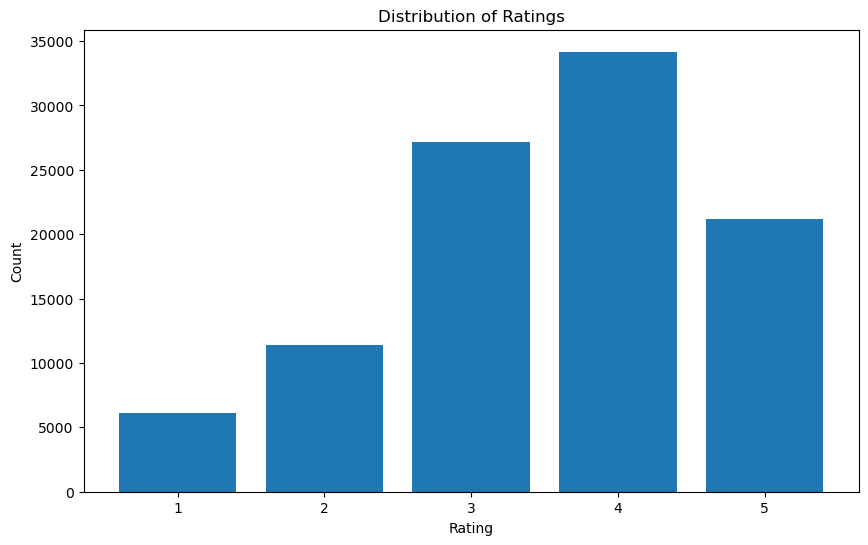

In [32]:
import matplotlib.pyplot as plt

# PLOT DISTRIBUTION OF RATINGS
ratings_count = df.groupBy("rating").count().orderBy("rating").toPandas()
plt.figure(figsize=(10, 6))
plt.bar(ratings_count["rating"], ratings_count["count"])
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.show()

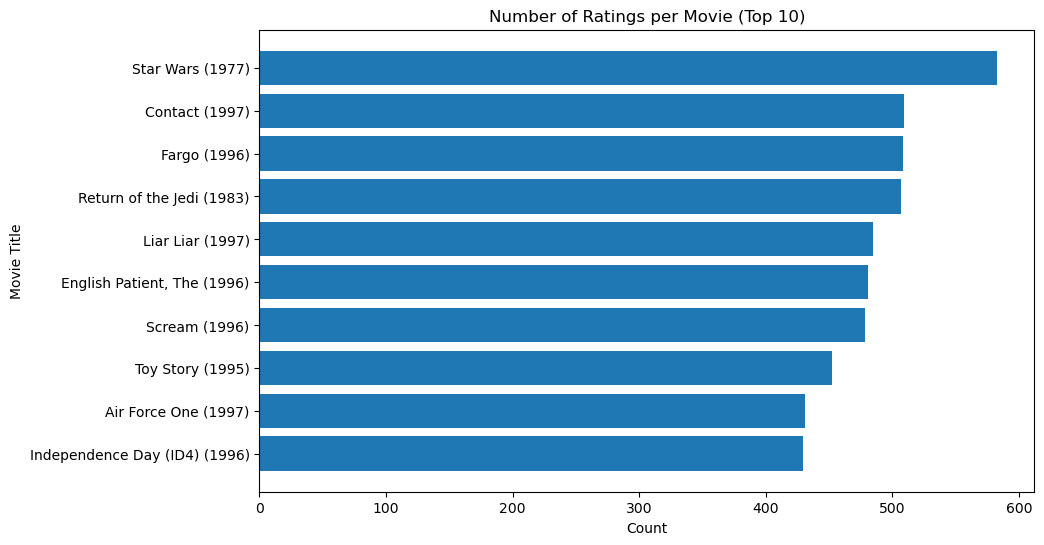

In [33]:
# PLOT NUMBER OF RATINGS PER MOVIE
movie_ratings_count = (
    df.groupBy("title").count().orderBy("count", ascending=False).limit(10).toPandas()
)
plt.figure(figsize=(10, 6))
plt.barh(movie_ratings_count["title"], movie_ratings_count["count"])
plt.xlabel("Count")
plt.ylabel("Movie Title")
plt.title("Number of Ratings per Movie (Top 10)")
plt.gca().invert_yaxis()
plt.show()

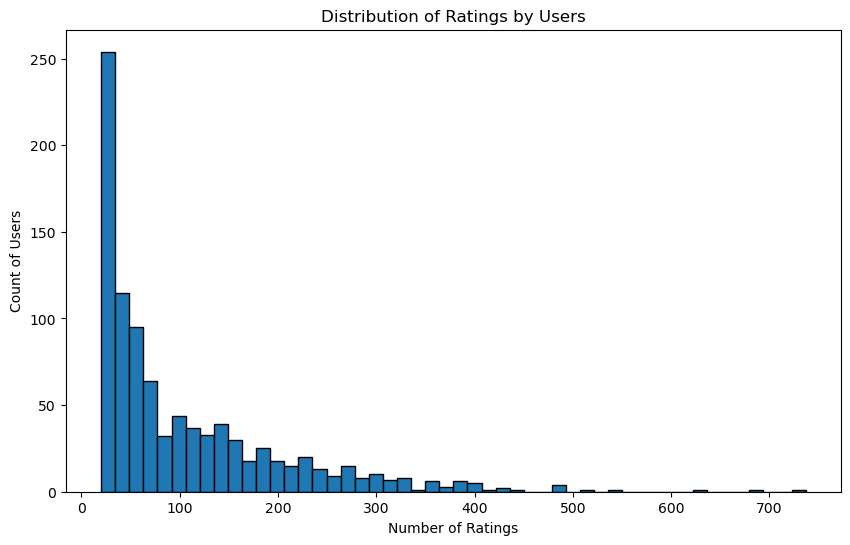

In [34]:
# PLOT DISTRIBUTION OF RATINGS BY USERS
user_ratings_count = df.groupBy("userId").count().orderBy("count").toPandas()
plt.figure(figsize=(10, 6))
plt.hist(user_ratings_count["count"], bins=50, edgecolor="black")
plt.xlabel("Number of Ratings")
plt.ylabel("Count of Users")
plt.title("Distribution of Ratings by Users")
plt.show()

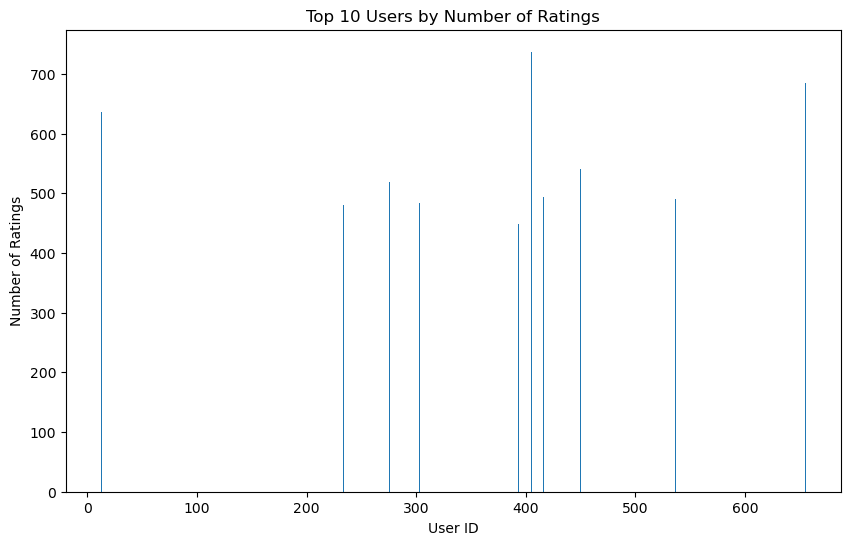

In [35]:
# PLOT TOP 10 USERS BY NUMBER OF RATINGS
top_users = user_ratings_count.nlargest(10, "count")
plt.figure(figsize=(10, 6))
plt.bar(top_users["userId"], top_users["count"])
plt.xlabel("User ID")
plt.ylabel("Number of Ratings")
plt.title("Top 10 Users by Number of Ratings")
plt.show()

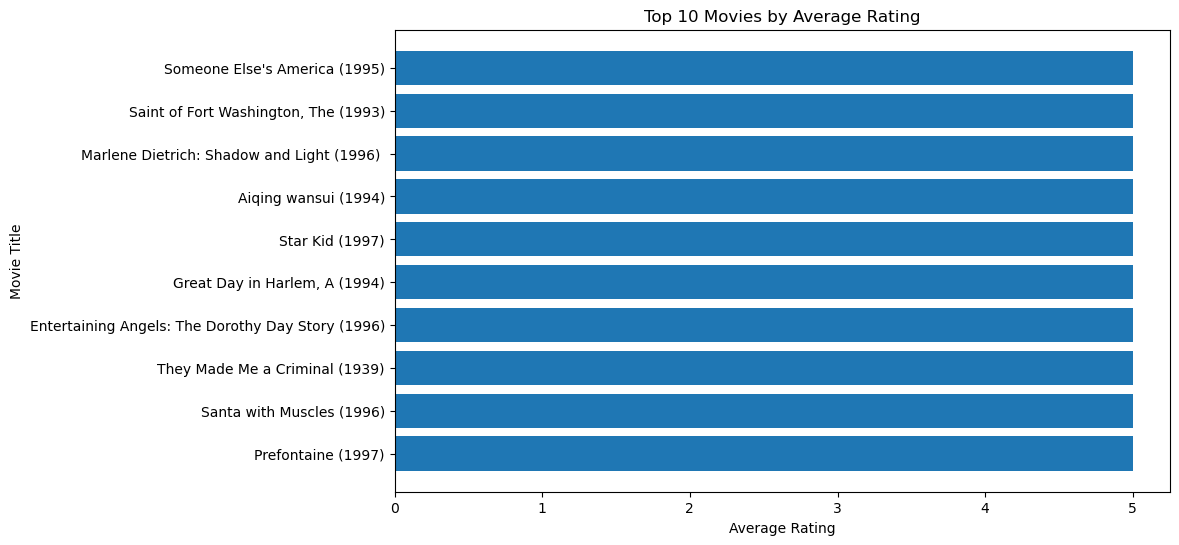

In [36]:
# PLOT AVERAGE RATING PER MOVIE
average_movie_ratings = (
    df.groupBy("title")
    .avg("rating")
    .orderBy("avg(rating)", ascending=False)
    .limit(10)
    .toPandas()
)
plt.figure(figsize=(10, 6))
plt.barh(average_movie_ratings["title"], average_movie_ratings["avg(rating)"])
plt.xlabel("Average Rating")
plt.ylabel("Movie Title")
plt.title("Top 10 Movies by Average Rating")
plt.gca().invert_yaxis()
plt.show()

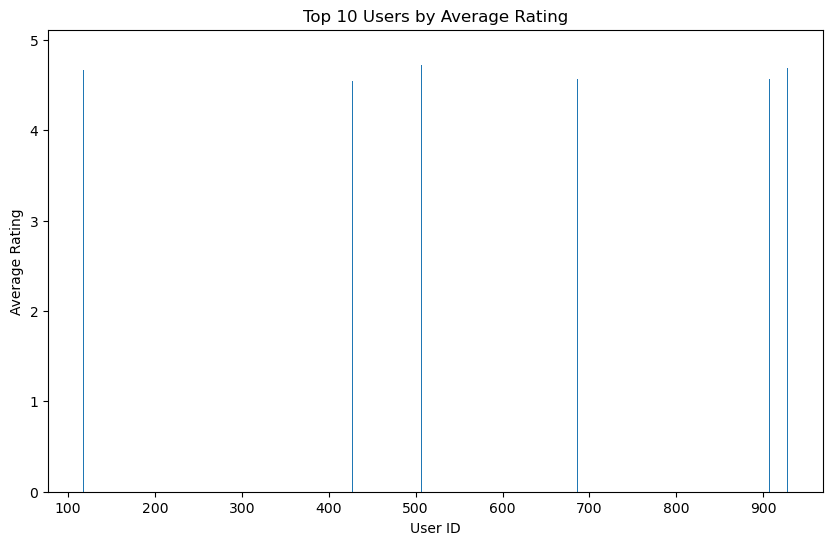

In [37]:
# PLOT AVERAGE RATING PER USER
average_user_ratings = (
    df.groupBy("userId")
    .avg("rating")
    .orderBy("avg(rating)", ascending=False)
    .limit(10)
    .toPandas()
)
plt.figure(figsize=(10, 6))
plt.bar(average_user_ratings["userId"], average_user_ratings["avg(rating)"])
plt.xlabel("User ID")
plt.ylabel("Average Rating")
plt.title("Top 10 Users by Average Rating")
plt.show()

## Get Predictions from the recommendations model
### Test: recommend 5 movies for user of id=60

In [38]:
top_movies(60, 5)

+---------+------+----------+-----------------------+
|title_new|userId|prediction|title                  |
+---------+------+----------+-----------------------+
|884.0    |60    |5.794795  |Ruby in Paradise (1993)|
|1063.0   |60    |5.7624617 |Alphaville (1965)      |
|1120.0   |60    |5.6162605 |Crooklyn (1994)        |
|950.0    |60    |5.566379  |Amateur (1994)         |
|1195.0   |60    |5.5589    |Love and a .45 (1994)  |
+---------+------+----------+-----------------------+

